# News Mood

## Analysis
#### Observed trend 1 - At the time of writting the analysis report (6/3), the last 100 twitter messages made by all the news organizations are, to some extent, negative (compound score < 0).
#### Observed trend 2 - Of the five news orgs, New York Times, with the average compound score equals to -0.004, has the most neutral comments on their twitter news channel.
#### Observed trend 3 - Overall, the most tweets made through the five news orgs are neutral by referring to the first plot of the sentitment analysis.


In [1]:
# Dependencies
import tweepy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Current date
today = datetime.today().strftime("%m/%d/%Y")
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (consumer_key,
                    consumer_secret,
                    access_token,
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

## Retrieving the data through Tweepy API

In [2]:
# Target twitter accounts and actual names
news_org_twitter_names = ['@BBCWorld','@CBSNews','@CNN','@FoxNews','@nytimes']
news_org_names = ['BBC','CBS','CNN','Fox','New York Times']
# A dictionary used to convert twitter account to actual name
twitter_name_to_actual_name ={'@BBCWorld':'BBC',
                              '@CBSNews':'CBS',
                              '@CNN':'CNN',
                              '@FoxNews':'Fox',
                              '@nytimes':'New York Times'}

# Colors for the news channels
color_names = ['lightskyblue','darkgreen','firebrick','mediumblue','gold']


colors = dict(zip(news_org_names, color_names))

In [3]:
# Create a function for the sentiment analysis of each news org
def get_sentiments(target_user):
    # Variables for holding sentiments
    sentiments = []

    # Counter
    counter = 1

    # Variable for max_id
    oldest_tweet = None
    
    # Loop through 5 pages of tweets (total 100 tweets)
    for x in range(5):

        # Get all tweets from home feed
        public_tweets = api.user_timeline(target_user, max_id = oldest_tweet)

        # Loop through all tweets 
        for tweet in public_tweets:

            # Print Tweets
            # print("Tweet %s: %s" % (counter, tweet["text"]))

            # Run Vader Analysis on each tweet
            results = analyzer.polarity_scores(tweet["text"])
            compound = results["compound"]
            pos = results["pos"]
            neu = results["neu"]
            neg = results["neg"]
            tweets_ago = counter

            # Get Tweet ID, subtract 1, and assign to oldest_tweet
            oldest_tweet = tweet['id'] - 1

            # Add sentiments for each tweet into a list
            media_source = twitter_name_to_actual_name.get(target_user)
            
                
            sentiments.append({"Media Sources":media_source,
                               "Compound": compound,
                               "Positive": pos,
                               "Negative": neg,
                               "Neutral": neu,
                               "Date": tweet["created_at"],
                               "Text": tweet["text"],
                               "Tweets Ago": counter})

            # Add to counter 
            counter += 1
    return sentiments

In [4]:
# Pull the data via Tweepy API
sentiments = list()
for target in news_org_twitter_names:
    sentiments += get_sentiments(target)

In [5]:
# Convert sentiments to DataFrame 
sentiments_pd = pd.DataFrame.from_dict(sentiments)
# Re-order the columns
sentiments_pd = sentiments_pd[['Media Sources','Negative','Neutral','Positive','Compound',
                               'Tweets Ago','Date','Text']]

In [6]:
# Visualize the dataframe
sentiments_pd.head()

,Media Sources,Negative,Neutral,Positive,Compound,Tweets Ago,Date,Text
0,BBC,0.287,0.463,0.250,-0.1027,1,Sun Jun 03 20:32:04 +0000 2018,San Diego marathon: 'Active shooter arrested' ...
1,BBC,0.167,0.833,0.000,-0.3400,2,Sun Jun 03 19:45:40 +0000 2018,Dancing FBI agent drops gun during backflip an...
2,BBC,0.000,0.748,0.252,0.4019,3,Sun Jun 03 18:11:52 +0000 2018,Slovenia election: Anti-immigrant SDS party le...
3,BBC,0.000,1.000,0.000,0.0000,4,Sun Jun 03 16:45:10 +0000 2018,Soyuz space capsule brings ISS crew back after...
4,BBC,0.000,0.858,0.142,0.1655,5,Sun Jun 03 16:25:39 +0000 2018,Trump 'could pardon himself over Russia but wo...


In [7]:
# Check the each news org has 100 tweets
groupby_media = sentiments_pd.groupby('Media Sources')
groupby_media.count()

,Negative,Neutral,Positive,Compound,Tweets Ago,Date,Text
Media Sources,,,,,,,
BBC,100,100,100,100,100,100,100
CBS,100,100,100,100,100,100,100
CNN,100,100,100,100,100,100,100
Fox,100,100,100,100,100,100,100
New York Times,100,100,100,100,100,100,100


In [8]:
# Save the dataframe to a CSV file
sentiments_pd.to_csv("news_mood.csv",index=False)

## Plotting sentiment analysis of media tweets

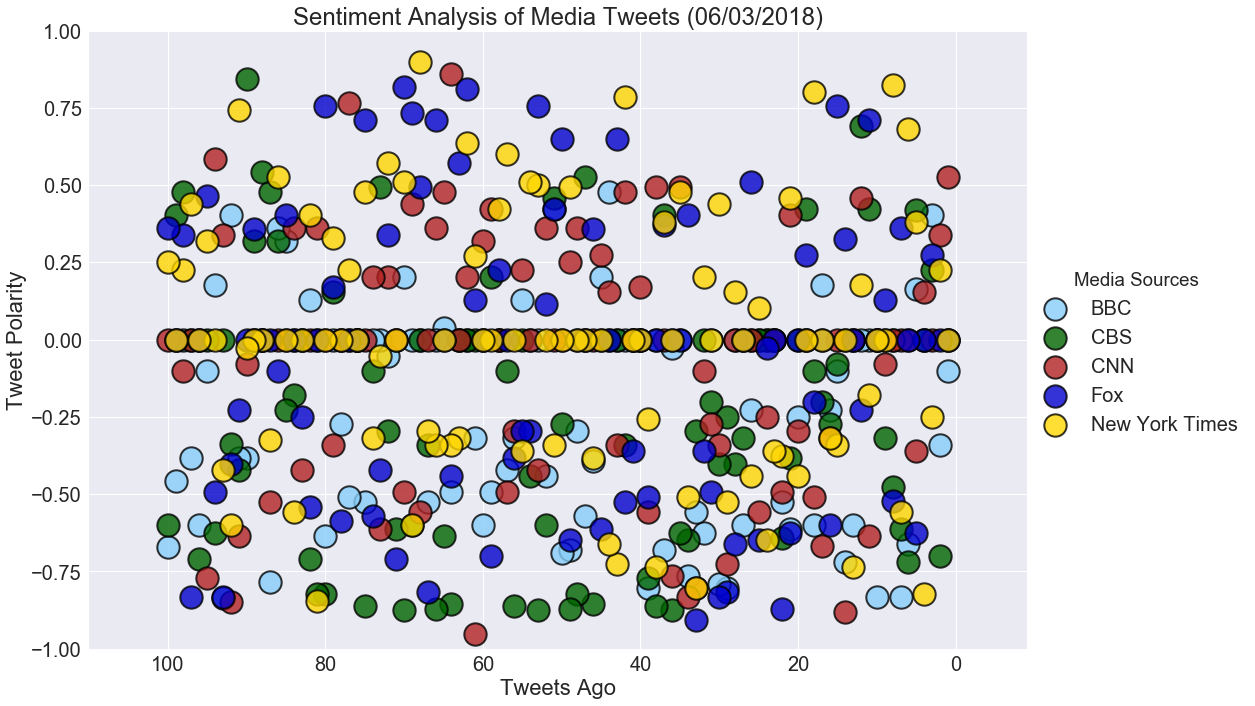

In [9]:
# Plot the sentiments
sns.set_style("darkgrid")
sns.set(font_scale = 2)
# plt.figure(figsize=(50,30))
g = sns.lmplot(x='Tweets Ago',
               y='Compound',
               data=sentiments_pd,
               scatter_kws={'edgecolors':'black',
                            'linewidths':2,
                            'alpha': 0.8,
                            's': 500},             
               hue='Media Sources',
               palette=colors,
               fit_reg=False,
               size=10,
               aspect=1.5,
               legend_out=True)

# set xlim and ylim
g.ax.set_xlim(sentiments_pd['Tweets Ago'].max()+10,sentiments_pd['Tweets Ago'].min()-10)
g.ax.set_ylim(-1,1)
# title, labels
g.ax.set_title(f"Sentiment Analysis of Media Tweets ({today})")
g.ax.set_xlabel("Tweets Ago")
g.ax.set_ylabel("Tweet Polarity")
# save the plot
plt.savefig('Plot1- sentiment analysis.png')
plt.show()

## Plotting overall media sentiment

In [10]:
overall_sentiments_series = sentiments_pd.groupby('Media Sources')['Compound'].mean()

In [11]:
colors = {'BBC': 'lightskyblue',
         'CBS': 'darkgreen',
         'CNN': 'firebrick',
         'Fox': 'mediumblue',
         'NYT': 'gold'}
add_color = lambda org: colors.get(org)

In [12]:
overall_sentiments_pd = overall_sentiments_series.to_frame()
overall_sentiments_pd.reset_index(inplace=True)
# Rename New York Times to NYT
indx=overall_sentiments_pd[overall_sentiments_pd['Media Sources']=='New York Times'].index
overall_sentiments_pd.loc[indx,'Media Sources'] = 'NYT'
# Add colors to the dataframe
overall_sentiments_pd['Colors'] = overall_sentiments_pd['Media Sources'].apply(add_color)

In [13]:
overall_sentiments_pd

,Media Sources,Compound,Colors
0,BBC,-0.215119,lightskyblue
1,CBS,-0.199131,darkgreen
2,CNN,-0.063043,firebrick
3,Fox,-0.045146,mediumblue
4,NYT,-0.003558,gold


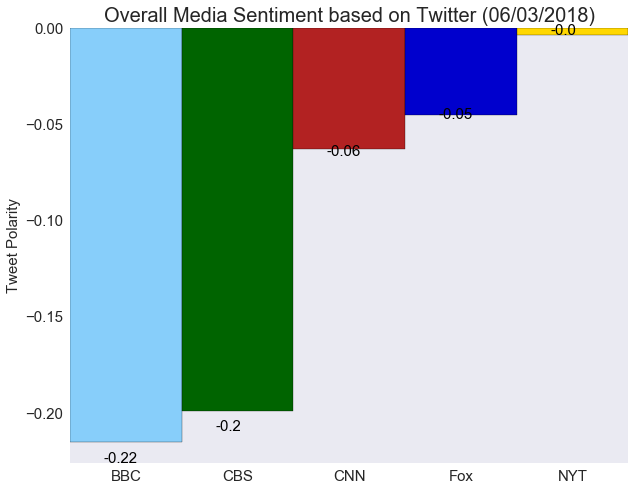

In [15]:
colors = overall_sentiments_pd['Colors'].values
sns.set_style('dark')
# sns.set(font_scale = 2)
ax = overall_sentiments_pd.plot(kind='bar',
                           x='Media Sources',
                           y='Compound',
                           width=1, 
                           color=colors,
                           legend=False,
                           edgecolor='black',
                           figsize=(10,8),
                           rot=0,
                           fontsize=15)
ax.set_title(f'Overall Media Sentiment based on Twitter ({today})', fontsize=20)
ax.set_ylabel("Tweet Polarity", fontsize=15)
ax.set_xlabel("")
ax.set_xlim(-.5,4.5)

# Revise the annotation position
pos = lambda p: p*(1.05) if p<0 else p

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.3, pos(i.get_height()), \
            str(round((i.get_height()), 2)), fontsize=15, color='black')
# save the plot
plt.savefig("Plot2 - overall media sentiment.png")
plt.show()